In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from itertools import chain
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [2]:
#load pre-trained embedding:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Minor Project/crawl-300d-2M.vec.zip", 'r')
zip_ref.extractall()
zip_ref.close()
embeddings_index = {}
f = open('/content/crawl-300d-2M.vec', encoding="utf8")
for line in f:
    values = line.split()#This splits each values in a  line with spaces
    word = values[0] # This store the first values which is the word in english
    coefs = np.asarray(values[1:], dtype='float32') # This converts all splitted values from 1 to last(expect first word) into an array
    embeddings_index[word] = coefs # english word = array of numerical values
f.close()
print('Total %s word vectors in crawl-300-2M.' % len(embeddings_index))

Total 1999996 word vectors in crawl-300-2M.


In [3]:
df = pd.read_csv("/content/drive/My Drive/Minor Project/agr_en_dev.csv", names= ['File_ID', 'Text', 'Label'])
df = df.drop(columns=['File_ID'])
df['Label'] = df['Label'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df.head()

,Text,Label
0,The quality of re made now makes me think it i...,1
1,@siva \nHow is ur mother???\nHow is ur wife???...,0
2,Also see ....hw ur RSS activist caught in Burk...,0
3,On the death of 2 jawans in LOC CROSS FIRING\n...,0
4,Modi ho ya Manmohan singh saala yeh log kuch n...,2


In [4]:
df1 = pd.read_csv("/content/drive/My Drive/Minor Project/agr_en_fb_gold.csv", names= ['File_ID', 'Text', 'Label'])
df1 = df1.drop(columns=['File_ID'])
df1['Label'] = df1['Label'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df1.head()

,Text,Label
0,If government of india don't take strict actio...,0
1,So now we know. The women should be under the ...,0
2,गद्दारो तुमसे ही तो खतरा है अबकी बार साफ हो जाओगे,0
3,Do you think markets are gonna be sideways til...,0
4,Jago Urjut Jago....\nSave common people from\n...,0


In [5]:
df2 = pd.read_csv("/content/drive/My Drive/Minor Project/agr_en_train.csv", names= ['File_ID', 'Text', 'Label'])
df2 = df2.drop(columns=['File_ID'])
df2['Label'] = df2['Label'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df2.head()

,Text,Label
0,Well said sonu..you have courage to stand agai...,2
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",0
2,"Now question is, Pakistan will adhere to this?",2
3,Pakistan is comprised of fake muslims who does...,2
4,"??we r against cow slaughter,so of course it w...",0


In [6]:
df3 = pd.read_csv("/content/drive/My Drive/Minor Project/agr_en_tw_gold.csv", names= ['File_ID', 'Text', 'Label'])
df3 = df3.drop(columns=['File_ID'])
df3['Label'] = df3['Label'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df3.head()

,Text,Label
0,6-0 hahahahahaha har ek pakistani ko yeh pic d...,0
1,@sardanarohit :While entire nation is praying ...,2
2,shoaib: wahab riaz looks like johnson. kapil d...,0
3,"ramraj cottons r. ashwin southindian , chennai...",0
4,#indvsuae jeet gaye... :) :) cmon starsports n...,0


In [7]:
df4 = pd.read_csv("/content/drive/My Drive/Minor Project/eng_train.csv")
df4 = df4.drop(columns=['ID', 'Sub-task B'])
df4 = df4.rename(columns={'Sub-task A' : 'Label'})
df4['Label'] = df4['Label'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df4.tail()

,Text,Label
4258,Abey loudey Arnab... Did u ever see the vedios...,2
4259,Arundati is very rich where she get money who ...,0
4260,People may criticize Pratik Borade by saying t...,1
4261,@Naaz Sk hello,0
4262,"We want to read your book sir, please make it ...",0


In [8]:
frames = [df, df1, df2, df3, df4]
train_df = pd.concat(frames)
train_df

,Text,Label
0,The quality of re made now makes me think it i...,1
1,@siva \nHow is ur mother???\nHow is ur wife???...,0
2,Also see ....hw ur RSS activist caught in Burk...,0
3,On the death of 2 jawans in LOC CROSS FIRING\n...,0
4,Modi ho ya Manmohan singh saala yeh log kuch n...,2
...,...,...
4258,Abey loudey Arnab... Did u ever see the vedios...,2
4259,Arundati is very rich where she get money who ...,0
4260,People may criticize Pratik Borade by saying t...,1
4261,@Naaz Sk hello,0


In [9]:
test_df = pd.read_csv("/content/drive/My Drive/Minor Project/eng_dev.csv")
test_df = test_df.drop(columns=['ID', 'Sub-task B'])
test_df = test_df.rename(columns={'Sub-task A' : 'Label'})
test_df['Label'] = test_df['Label'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
test_df

,Text,Label
0,U deserve more subscribers. U really great.,0
1,Nice video....,0
2,sorry if i bother somebody.. iam a defence asp...,0
3,Joker was amazing....it was not glamorised !.....,0
4,Nice baro,0
...,...,...
1061,Ranu Mandal is third class [woman.No](http://w...,2
1062,[15:23](https://www.youtube.com/watch?v=N_ZMfQ...,0
1063,Love u bro keep it up,0
1064,May I help you?,0


In [10]:
train_df.shape, test_df.shape

((21436, 2), (1066, 2))

In [11]:
print(train_df['Label'].value_counts())
print(test_df['Label'].value_counts())

0    10772
1     6305
2     4359
Name: Label, dtype: int64
0    836
1    117
2    113
Name: Label, dtype: int64


In [12]:
train_line=train_df['Text'].apply(lambda x: nltk.word_tokenize(x))
dev_line=test_df['Text'].apply(lambda x: nltk.word_tokenize(x))
dev_line,train_line

(0       [U, deserve, more, subscribers, ., U, really, ...
 1                                   [Nice, video, ..., .]
 2       [sorry, if, i, bother, somebody.., iam, a, def...
 3       [Joker, was, amazing, ..., .it, was, not, glam...
 4                                            [Nice, baro]
                               ...                        
 1061    [Ranu, Mandal, is, third, class, [, woman.No, ...
 1062    [[, 15:23, ], (, https, :, //www.youtube.com/w...
 1063                         [Love, u, bro, keep, it, up]
 1064                               [May, I, help, you, ?]
 1065    [You, are, great, sir, !, !, !, When, a, i, sa...
 Name: Text, Length: 1066, dtype: object,
 0       [The, quality, of, re, made, now, makes, me, t...
 1       [@, siva, How, is, ur, mother, ?, ?, ?, How, i...
 2       [Also, see, ..., .hw, ur, RSS, activist, caugh...
 3       [On, the, death, of, 2, jawans, in, LOC, CROSS...
 4       [Modi, ho, ya, Manmohan, singh, saala, yeh, lo...
              

In [13]:
tk=Tokenizer(lower=True,split=" ")
tk.fit_on_texts(train_line)
word_index=tk.word_index
word_index

{'.': 1,
 'the': 2,
 'to': 3,
 ',': 4,
 'and': 5,
 'is': 6,
 'of': 7,
 '...': 8,
 'in': 9,
 'a': 10,
 '?': 11,
 'for': 12,
 'you': 13,
 'are': 14,
 'it': 15,
 'i': 16,
 'not': 17,
 '!': 18,
 'this': 19,
 'that': 20,
 'on': 21,
 'be': 22,
 '#': 23,
 'he': 24,
 'will': 25,
 'have': 26,
 'do': 27,
 'they': 28,
 'with': 29,
 'we': 30,
 "'s": 31,
 'india': 32,
 "n't": 33,
 'by': 34,
 'but': 35,
 'all': 36,
 ':': 37,
 'u': 38,
 'people': 39,
 'from': 40,
 'as': 41,
 'what': 42,
 'your': 43,
 'like': 44,
 'who': 45,
 'can': 46,
 'so': 47,
 'if': 48,
 'has': 49,
 'or': 50,
 'was': 51,
 'no': 52,
 'should': 53,
 ')': 54,
 'indian': 55,
 'their': 56,
 'only': 57,
 'about': 58,
 'his': 59,
 'our': 60,
 'one': 61,
 'why': 62,
 'just': 63,
 '&': 64,
 'at': 65,
 'now': 66,
 '(': 67,
 'good': 68,
 'there': 69,
 'any': 70,
 'bjp': 71,
 'how': 72,
 'more': 73,
 'them': 74,
 'time': 75,
 '@': 76,
 'then': 77,
 'modi': 78,
 'also': 79,
 'very': 80,
 'these': 81,
 'an': 82,
 'my': 83,
 'some': 84,
 'when'

In [14]:
import math
length=math.ceil(np.average(train_line.apply(lambda x:len(x))))
length

26

In [0]:
def encode_text(tokenizer, lines, length):
  encoded = tokenizer.texts_to_sequences(lines)
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

In [16]:
train_x=encode_text(tk,train_line,length)
print(train_x)
dev_x=encode_text(tk,dev_line,length)
print(dev_x)

[[    2  1082     7 ...     0     0     0]
 [    6   124   503 ...  1391     8 15550]
 [   79   106     8 ...     0     0     0]
 ...
 [    1 37725    53 ... 37726   457    18]
 [   76 37727  9269 ...     0     0     0]
 [   30   121     3 ...     0     0     0]]
[[   38   781    73 ...     0     0     0]
 [  229   179     8 ...     0     0     0]
 [ 1041     7  4076 ... 11637    69     8]
 ...
 [  148    38   261 ...     0     0     0]
 [  178    16   298 ...     0     0     0]
 [   13    14   141 ...     0     0     0]]


In [17]:
vocab_size = len(tk.word_index)
print(vocab_size)

37727


In [18]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(train_df['Label']))
y_test = to_categorical(np.asarray(test_df['Label']))
# y_train=np.array(train_df['Sub-task A'])
# y_dev=np.array(dev_df['Sub-task A'])
print(y_train.shape, y_test.shape)

(21436, 3) (1066, 3)


In [0]:
# Initialize the weight for each word for the embedding layer. Words not present
# in the dictionary initialized by random value 
EMBEDDING_DIM = 300
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#embedding_matrix = (10370, 300) NOTE: It is from uniques words in our tweets
for word, i in word_index.items(): # Selecting word from our tweet unique words list for changing with the values from glove
    embedding_vector = embeddings_index.get(word) # Finding our tweet words in glove and taking its array of 100 values
    if embedding_vector is not None: 
#words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 300, weights=[embedding_matrix], input_length=length,trainable=False))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 300)           11318400  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 128)           115328    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131

In [23]:
history=model.fit(train_x, y_train, validation_data = (dev_x, y_test),epochs=120,batch_size=100, verbose=2)

Train on 21436 samples, validate on 1066 samples
Epoch 1/120
 - 2s - loss: 0.2062 - acc: 0.9235 - val_loss: 1.0261 - val_acc: 0.7186
Epoch 2/120
 - 2s - loss: 0.2110 - acc: 0.9205 - val_loss: 0.9823 - val_acc: 0.7205
Epoch 3/120
 - 2s - loss: 0.2090 - acc: 0.9220 - val_loss: 0.9429 - val_acc: 0.7214
Epoch 4/120
 - 2s - loss: 0.2088 - acc: 0.9224 - val_loss: 0.9910 - val_acc: 0.7205
Epoch 5/120
 - 2s - loss: 0.2026 - acc: 0.9251 - val_loss: 1.0041 - val_acc: 0.7242
Epoch 6/120
 - 2s - loss: 0.2034 - acc: 0.9261 - val_loss: 1.0483 - val_acc: 0.7129
Epoch 7/120
 - 2s - loss: 0.2006 - acc: 0.9266 - val_loss: 1.0918 - val_acc: 0.7176
Epoch 8/120
 - 2s - loss: 0.2013 - acc: 0.9262 - val_loss: 1.0188 - val_acc: 0.7120
Epoch 9/120
 - 2s - loss: 0.2009 - acc: 0.9270 - val_loss: 1.0425 - val_acc: 0.7036
Epoch 10/120
 - 2s - loss: 0.1995 - acc: 0.9262 - val_loss: 1.0322 - val_acc: 0.7111
Epoch 11/120
 - 2s - loss: 0.1905 - acc: 0.9295 - val_loss: 1.0524 - val_acc: 0.7214
Epoch 12/120
 - 2s - loss

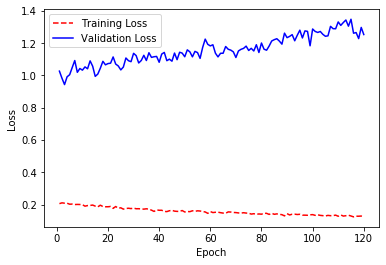

In [24]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
scores = model.evaluate(dev_x, y_test, verbose=0)
print(scores)

[1.2526290690138462, 0.7363977487046991]


In [26]:
predictions_test = model.predict(dev_x)
print(predictions_test)

[[1.0000000e+00 2.0013932e-08 6.4622732e-13]
 [1.0000000e+00 1.3896303e-13 4.0703600e-09]
 [9.4879156e-01 5.0379273e-02 8.2916417e-04]
 ...
 [1.0000000e+00 3.2690793e-13 4.1553356e-14]
 [9.5383167e-01 4.5873698e-02 2.9464142e-04]
 [1.0000000e+00 4.6091937e-12 1.1439272e-13]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       836
           1       0.25      0.27      0.26       117
           2       0.43      0.52      0.47       113

   micro avg       0.74      0.74      0.74      1066
   macro avg       0.52      0.54      0.53      1066
weighted avg       0.75      0.74      0.74      1066
 samples avg       0.74      0.74      0.74      1066

